# Sentinel-2 Reservoir and Lake Surface Area Monitoring

This notebook shows how to use <b>Sentinel-2 Reservoir and Lake Surface Area Monitoring</b> processing block to map changes in surface extents of water bodies. In this example, we will visualize the impact of recent droughts on some of the reservoirs in Taiwan.

The notebook is divided in following sections:
1. Define AOI and time range.
2. Validate the AOI and time range to ensure that Sentinel-2 imagery is available.
3. Run the workflow to generate water extent maps for pre-defined water bodies within the AOI. 
4. Download raw multi-spectral imagery for visual comparison.
5. Visualize surface water extent maps

Please note that this example assumes that your project settings allow:
- jobs can be executed in parallel
- at least 20 images can be returned as output
- maximum AOI size limit is greater than 15 square kilometers.

If the above settings are not feasible for your project, please adjust the AOI size and time range accordingly.

**Please note**, this workflow takes approximately 1 hour to run.

In [1]:
# load packages
import os
from functools import partial

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyproj
import rasterio
import rasterio.mask
from rasterio import features
from rasterio.plot import reshape_as_raster, show
from shapely.geometry import LineString, MultiPolygon, Point, Polygon, box
from shapely.geometry import shape as shapely_shp
from shapely.ops import cascaded_union, transform
from rasterio.plot import show
from datetime import date
from dateutil.relativedelta import relativedelta

import folium
import up42
import geopandas
import time
import math
import glob
from matplotlib.colors import LinearSegmentedColormap
# allows for ignoring errors + division by zero
np.seterr(divide='ignore', invalid='ignore')


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
# provide your project id and project api key in a config file
up42.authenticate(cfg_file="config.json")
project = up42.initialize_project()
project.update_project_settings(max_concurrent_jobs=20)
project.update_project_settings(number_of_images=40)

2021-07-26 08:22:41,489 - Got credentials from config file.
2021-07-26 08:22:42,200 - Authentication with UP42 successful!
2021-07-26 08:22:42,920 - Initialized Project(name: Blocks, project_id: 810e8039-cb5c-445b-b08d-53b0dde1bde0, description: , createdAt: 2020-07-13T14:32:49.406Z)
2021-07-26 08:22:43,359 - Updated project settings: [{'name': 'JOB_QUERY_MAX_AOI_SIZE', 'value': '100'}, {'name': 'MAX_CONCURRENT_JOBS', 'value': '20'}, {'name': 'JOB_QUERY_LIMIT_PARAMETER_MAX_VALUE', 'value': '10'}]
2021-07-26 08:22:43,755 - Updated project settings: [{'name': 'JOB_QUERY_MAX_AOI_SIZE', 'value': '100'}, {'name': 'MAX_CONCURRENT_JOBS', 'value': '10'}, {'name': 'JOB_QUERY_LIMIT_PARAMETER_MAX_VALUE', 'value': '40'}]


## 1. Define AOI and time range.

In [4]:
# set AOI (as JSON format dictionary). To get AOI as JSON, please use http://geojson.io
aoi = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
                "coordinates": [
            [
              [
                121.051051,
                24.758307
              ],
              [
                121.027337,
                24.747545
              ],
              [
                121.036327,
                24.735015
              ],
              [
                121.032854,
                24.722302
              ],
              [
                121.043744,
                24.711475
              ],
              [
                121.055938,
                24.715882
              ],
              [
                121.078329,
                24.730913
              ],
              [
                121.051051,
                24.758307
              ]
            ]
          ]
        }
    }
  ]
}
aoi = aoi['features'][0]['geometry']

# Set start and end date arrays. This allows comparison across non-consecutive time periods
# In this example, we intend to compare water extents of 7 months ago with extents of 2 months ago (this is necessary because Sobloo has a rolling archive)
time_interval_1_end = date.today() + relativedelta(months=-7)
time_interval_1_start = date.today() + relativedelta(months=-7, days=-14)
time_interval_2_end = date.today() + relativedelta(months=-2)
time_interval_2_start = date.today() + relativedelta(months=-2, days=-14)

time_interval_1 = (time_interval_1_start, time_interval_1_end)
time_interval_2 =   (time_interval_2_start, time_interval_2_end)

limit = 10 #set the limit on number of images
num_parallel_jobs = 10 #set the limit on number of parallel tasks

# set up working directories
dry_run_dir = './realsat_demo_dryrun/'
map_run_dir = './realsat_demo_maps/'
img_run_dir = './realsat_demo_imgs/'


## 2. Validate the AOI and time range.

In [5]:
# run the data block first in DRY_RUN mode to confirm that the query returns non-zero number of sentinel-2 images

# initialize workflow
workflow = project.create_workflow(name="realsat_demo", use_existing=True)

# declare workflow tasks
input_tasks = ['sobloo-s2-l1c-fullscene']

# Update workflow object with our desired data block as input_task
workflow.add_workflow_tasks(input_tasks=input_tasks)

input_parameters = workflow.construct_parameters_parallel(
        geometries=[aoi], 
        geometry_operation='intersects',
        interval_dates=[time_interval_1, time_interval_2],
        limit_per_job=limit)

# run the job in dry run mode
job = workflow.test_jobs_parallel(input_parameters_list=input_parameters, max_concurrent_jobs=num_parallel_jobs)

# download results upon job completion
results = job.download_results(dry_run_dir)

# load metadata to print number of available images within the AOI and time range
metadata = geopandas.read_file(dry_run_dir + 'data.json')
num_images = metadata.shape[0]
print('Number of images available: ' + str(metadata.shape[0]))

2021-07-26 08:25:28,644 - Getting existing workflows in project ...
2021-07-26 08:25:29,015 - Got 208 workflows for project 810e8039-cb5c-445b-b08d-53b0dde1bde0.
100%|██████████| 208/208 [01:16<00:00,  2.72it/s]
2021-07-26 08:26:45,498 - Using existing workflow: realsat_demo - 48409e2d-f50c-43f5-a1e8-c2bbd0b7fa92
2021-07-26 08:26:49,360 - Added tasks to workflow: [{'name': 'sobloo-s2-l1c-fullscene:1', 'parentName': None, 'blockId': '98c1acfa-c141-4095-b2e6-acf52d110178'}]
2021-07-26 08:26:50,287 - +++++++++++++++++++++++++++++++++
2021-07-26 08:26:50,287 - Running this job as Test Query...
2021-07-26 08:26:50,288 - +++++++++++++++++++++++++++++++++
2021-07-26 08:26:50,288 - +++++++++++++++++++++++++++++++++
2021-07-26 08:26:50,289 - Running this job as Test Query...
2021-07-26 08:26:50,289 - +++++++++++++++++++++++++++++++++
2021-07-26 08:26:50,651 - Selected input_parameters: {'sobloo-s2-l1c-fullscene:1': {'time': '2020-11-12T00:00:00Z/2020-11-26T23:59:59Z', 'limit': 10, 'max_cloud_co

Number of images available: 9


## 3. Run the workflow to generate water extent maps. 
- The processing block will analyze pre-defined water bodies within the AOI.

In [ ]:
# run the workflow in live mode with the the processing block

# initialize workflow
workflow = project.create_workflow(name="realsat_demo")

# add the processing block
input_tasks = ['sobloo-s2-l1c-fullscene','terracover-realsat']

# Update workflow object with our desired data block as input_task
workflow.add_workflow_tasks(input_tasks=input_tasks)

# extracting scene ids to create job parameters for parallel execution
scene_ids_list = []
for i in range(metadata.shape[0]):
    cur_name = metadata['identification'].values[i]['externalId']
    scene_ids_list.append(cur_name)


# dividing the scenes into batches to submit multiple jobs for faster execution
batch_size = math.floor(num_images/num_parallel_jobs)
num_remaining = num_images%num_parallel_jobs
i = 0
total = 0
input_parameters_list = []

while (i<num_parallel_jobs):
    if i < num_remaining:
        adjusted_batch_size = batch_size+1
    else:
        adjusted_batch_size = batch_size
    input_parameters = workflow.construct_parameters(geometry=aoi,
                                                     geometry_operation="intersects",
                                                     scene_ids=scene_ids_list[total:total+adjusted_batch_size])
    # adding processing block parameters
    input_parameters['terracover-realsat:1']['intersects'] = aoi
    input_parameters['terracover-realsat:1']['bbox'] = None
    input_parameters['terracover-realsat:1']['contains'] = None
    # in case number of images found exceeds the number of parallel tasks
    if input_parameters["sobloo-s2-l1c-fullscene:1"]["limit"] != 0:
        input_parameters_list.append(input_parameters)
    i = i + 1
    total = total + adjusted_batch_size

# submit job
job2 = workflow.run_jobs_parallel(input_parameters_list=input_parameters_list, max_concurrent_jobs=num_parallel_jobs)

# download results upon completion
results = job2.download_results(map_run_dir)   

## 4. Download raw multi-spectral imagery for visual comparison.
- Since the above workflow does not return raw multi-spectral imagery, we need to run the data block in the live mode to download raw imagery for visual comparison 

In [ ]:
metadata = geopandas.read_file(dry_run_dir + 'data.json')
num_images = metadata.shape[0]

# initialize workflow
workflow = project.create_workflow(name="realsat_demo")

# declare workflow tasks
input_tasks = ['sobloo-s2-l1c-fullscene']

# Update workflow object with our data block as input_task
workflow.add_workflow_tasks(input_tasks=input_tasks)

# extracting scene ids to create job parameters for parallel execution
scene_ids_list = []
for i in range(metadata.shape[0]):
    cur_name = metadata['identification'].values[i]['externalId']
    scene_ids_list.append(cur_name)

# for constructing the parameters for parallel jobs create a list containing the aoi
input_parameters = workflow.construct_parameters_parallel(geometries=[aoi], 
                              interval_dates=None, 
                              scene_ids=scene_ids_list, 
                              limit_per_job=limit, 
                              geometry_operation='intersects')

job3 = workflow.run_jobs_parallel(input_parameters_list=input_parameters, max_concurrent_jobs=num_parallel_jobs)

# download results upon completion
results = job3.download_results(img_run_dir)   

## 5. Visualize surface water extent maps

In [9]:
def visualization_function(selected_tile:str = None):
    # define color schemes for water extent maps
    colors = [(0, 0.8, 0), (0, 0, 0.8), (1, 1, 1)]  # land: green, water: blue, clouds/missing data: white
    cmap = LinearSegmentedColormap.from_list('water_extent_color_map', colors, N=3)

    metadata = geopandas.read_file(map_run_dir + 'data.json')

    # extract IDs of water bodies detected within the AOI
    water_body_ids = metadata['WATER_BODY_ID'].values
    water_body_ids = list(set(water_body_ids))
    num_water_bodies = len(water_body_ids)
    print('Total number of water bodies within the AOI: ' + str(num_water_bodies))

    # # get the list of NIR band from all images. This list is used to 
    # raw_image_bands = glob.glob(img_run_dir + '*/*/*/GRANULE/*/IMG_DATA/*_B08.jp2')

    # loop through each water body
    for wbctr in range(len(water_body_ids)):

        water_body_id = water_body_ids[wbctr]
        print('Plotting results for water body: ' + water_body_id)

        # subset the metadata to retrieve information for the current water body
        water_body_metadata = metadata[metadata['WATER_BODY_ID'] == water_body_id]
        # get relative path of water extent maps 
        map_paths = water_body_metadata['up42.data_path'].values
        # reversing the list to make it chronological
        map_paths = map_paths[::-1]
        if selected_tile:
            map_paths = [i for i in map_paths if selected_tile in i]
        num_maps = len(map_paths)

        for t in range(num_maps):
            cur_map_file = map_run_dir + map_paths[int(t)]
            # get scene id 
            cur_scene_id = cur_map_file.split('/')[-1].split(water_body_id)[1][1:-4]
            #         cur_band_file = [i for i in raw_image_bands if cur_scene_id in i][0]
            # get absolute band of red,green,blue and nir bands
            red_band_file = glob.glob(img_run_dir + '*/*/' + cur_scene_id + '.SAFE/GRANULE/*/IMG_DATA/*_B04.jp2')[0]
            green_band_file = glob.glob(img_run_dir + '*/*/' + cur_scene_id + '.SAFE/GRANULE/*/IMG_DATA/*_B03.jp2')[0]
            blue_band_file = glob.glob(img_run_dir + '*/*/' + cur_scene_id + '.SAFE/GRANULE/*/IMG_DATA/*_B02.jp2')[0]
            nir_band_file = glob.glob(img_run_dir + '*/*/' + cur_scene_id + '.SAFE/GRANULE/*/IMG_DATA/*_B08.jp2')[0]

            # get bounds of current map file to subset sentinel bands
            ds = rasterio.open(cur_map_file)
            bounds = ds.bounds
            geom = box(*bounds)
            da = ds.read(1)
            ds.close()
            # skip maps that have no valid pixels
            if np.sum(da != 2) == 0:
                continue

            # initialize the figure with three subplots - 1) water extent map, 2) true color composite, 3) false color composite
            f, ax = plt.subplots(1, 3, figsize=(10, 40))
            ax[0].imshow(da, vmin=0, vmax=2, cmap=cmap)

            # reading and clip sentinel bands to match with water extent maps
            with rasterio.open(red_band_file) as src:
                red_image, out_transform = rasterio.mask.mask(src, [geom], crop=True)
            src.close()
            with rasterio.open(green_band_file) as src:
                green_image, out_transform = rasterio.mask.mask(src, [geom], crop=True)
            src.close()
            with rasterio.open(blue_band_file) as src:
                blue_image, out_transform = rasterio.mask.mask(src, [geom], crop=True)
            src.close()
            with rasterio.open(nir_band_file) as src:
                nir_image, out_transform = rasterio.mask.mask(src, [geom], crop=True)
            src.close()

            # create true color composite
            rgb_image = np.concatenate((red_image, green_image, blue_image), axis=0)
            rgb_image = np.transpose(rgb_image, (1, 2, 0))
            rgb_image = (rgb_image - np.min(rgb_image)) * 1.0 / (np.max(rgb_image) - np.min(rgb_image))
            rgb_image = np.clip(rgb_image, 0, 1)
            ax[1].imshow(rgb_image)

            # create false color composite
            fcc_image = np.concatenate((nir_image, red_image, green_image), axis=0)
            fcc_image = np.transpose(fcc_image, (1, 2, 0))
            fcc_image = (fcc_image - np.min(fcc_image)) * 1.0 / (np.max(fcc_image) - np.min(fcc_image))
            fcc_image = np.clip(fcc_image, 0, 1)
            ax[2].imshow(fcc_image)
            # add imagery date
            ax[0].set_title('Date: ' + cur_scene_id.split('_')[2][0:8])
            # add sentinel tile id 
            ax[1].set_title('Sentinel Tile: ' + cur_scene_id.split('_')[-2])
            # add water body id
            ax[2].set_title('ID: ' + water_body_id)
            plt.tight_layout()
            plt.show()

Total number of water bodies within the AOI: 2
Plotting results for water body: 029403


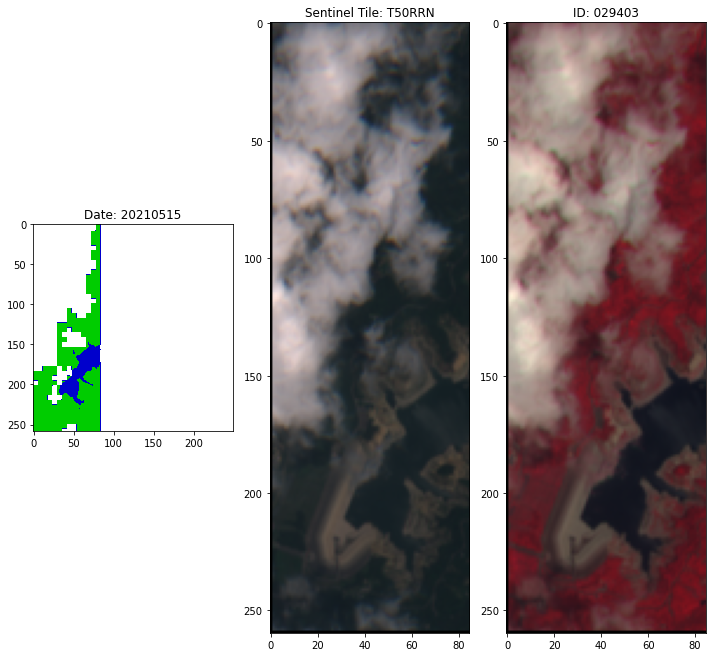

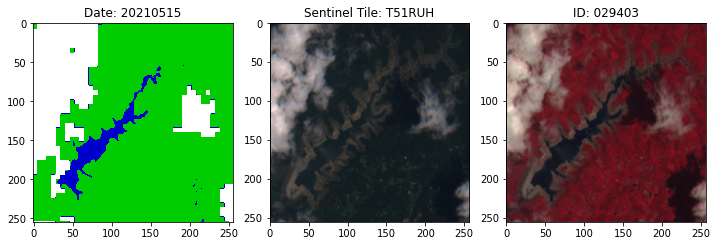

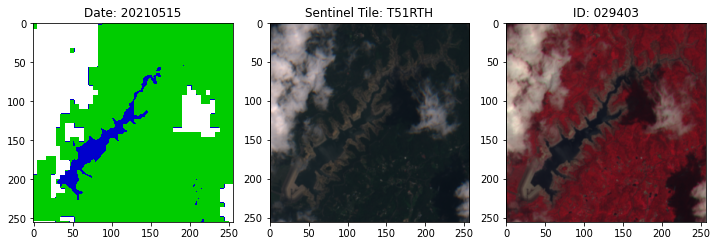

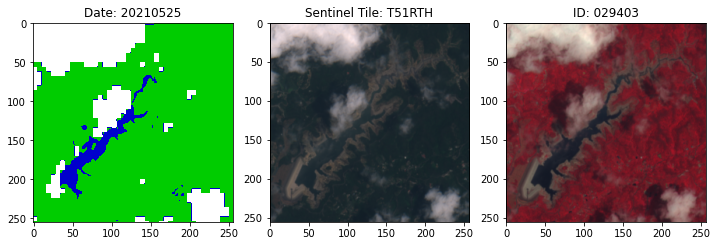

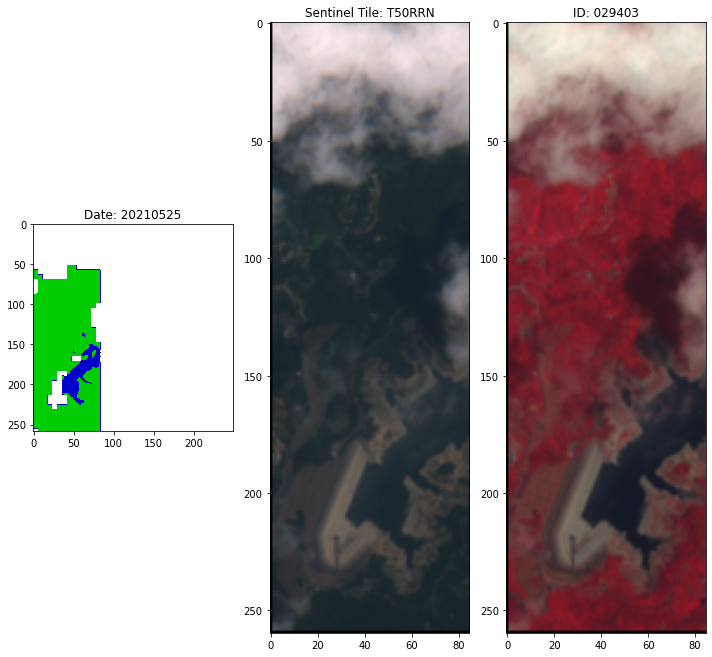

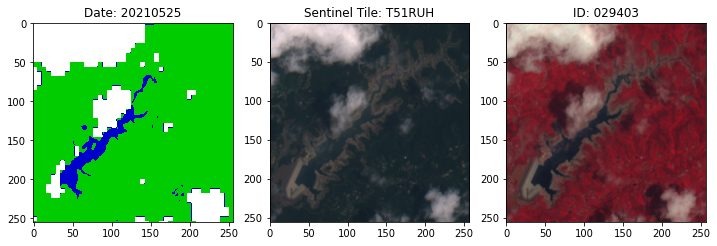

Plotting results for water body: 029402


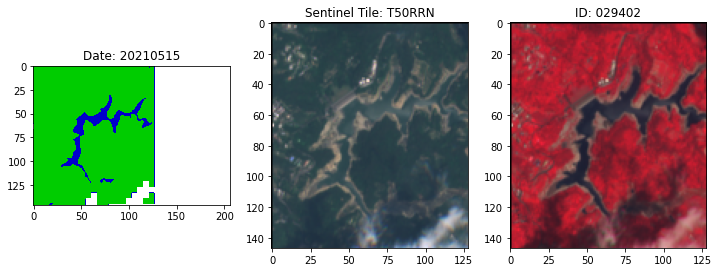

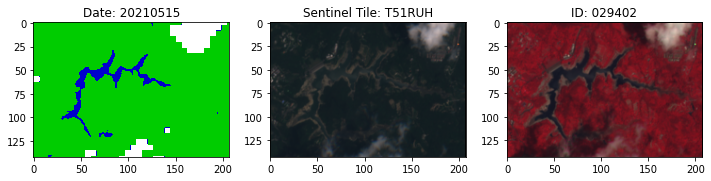

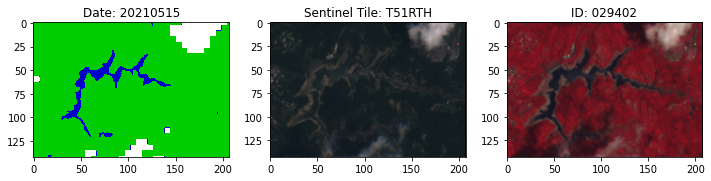

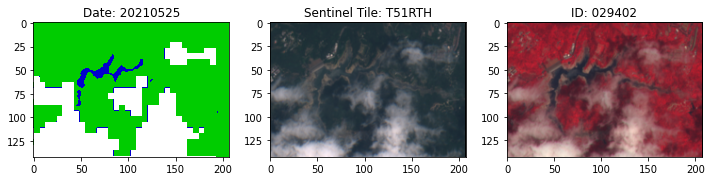

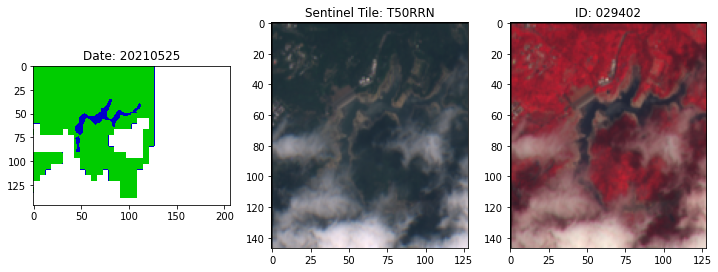

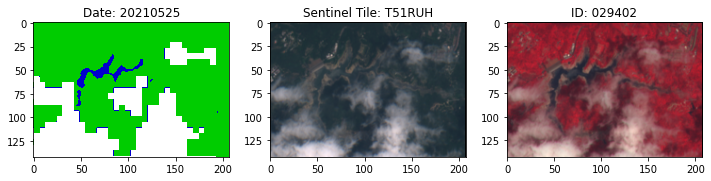

In [10]:
visualization_function()

#### Since these water bodies are in the region where sentinel tiles T51RTH and T50RRN overlap, we get two water extent maps for each timestamp. Next, we plot only images and map generated using sentinel tile T51RTH to reduce redundancy

#### Notice how our deep learning model is robust to cloud shadows.

Total number of water bodies within the AOI: 2
Plotting results for water body: 029403


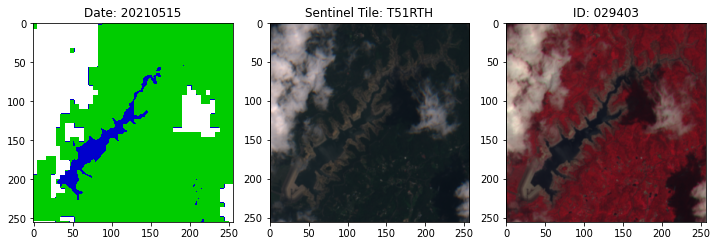

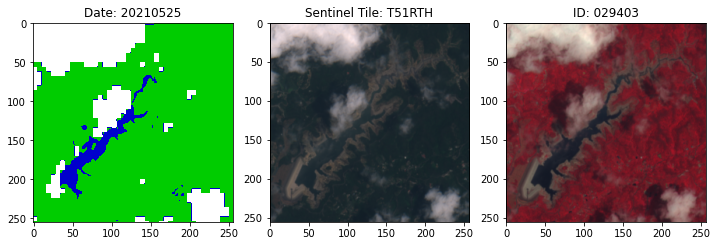

Plotting results for water body: 029402


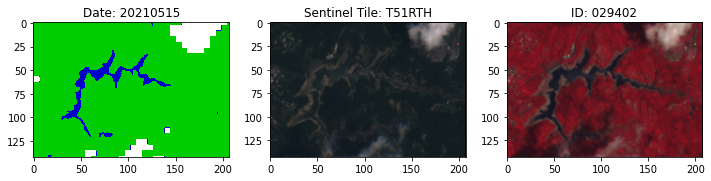

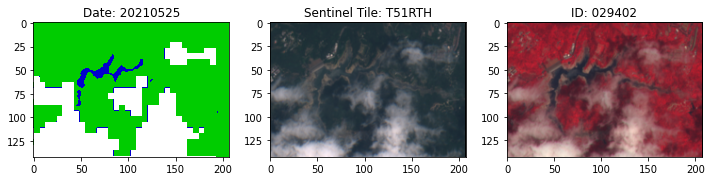

In [11]:
visualization_function(selected_tile = 'T51RTH')